In [72]:
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import ols
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import ttest_ind
from itertools import combinations
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve



<div class="alert alert-block alert-info">
DALAS TME 7 - Protocole d'evaluation en ML
</div>

# Analyse du dataset

<div class="alert alert-block alert-info">
Dans cette partie du TP, nous allons observer et comprendre les données. Vous serez guide.e.s pour les analyses à faire, cependant reflechissez à ce que cela nous dit sur les données.

Le dataset (https://www.cv-foundation.org/openaccess/content_cvpr_2016_workshops/w21/papers/De_Smedt_Skeleton-Based_Dynamic_Hand_CVPR_2016_paper.pdf) est pour la reconnaissance des gestes, nous avons les données de 28 senseurs (chaque senseur sera une dimension), et les informations sur les différents utilisateurs (il y en a combien? qu'est-ce que cela implique?) et le target c'est la classe correspondante au geste (on a combien de gestes différents?).
</div>

In [4]:
# Load the data from the HDF5 file, and create a pandas DataFrame
with h5py.File("SG24_dataset.h5", "r") as f:
    data = pd.DataFrame(np.array(f["Predictors"]).T)
    data["target"] = np.array(f["Target"]).flatten()
    data["user"] =  np.array(f["User"]).flatten()

data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,target,user
0,0.0,0.0,0.0,0.145442,0.0,-0.989367,0.0,77.0,67.0,74.0,...,91.0,96.0,0.0,83.0,33.0,136.0,140.0,143.0,1,1
1,0.0,0.0,0.0,0.195537,0.0,-0.980696,0.0,20.0,131.0,127.0,...,119.0,64.0,82.0,105.0,119.0,79.0,103.0,82.0,1,1
2,0.0,0.0,0.0,0.294340,0.0,-0.955701,0.0,22.0,139.0,134.0,...,130.0,68.0,86.0,106.0,131.0,75.0,105.0,89.0,1,1
3,0.0,0.0,0.0,0.352911,0.0,-0.935657,0.0,7.0,135.0,137.0,...,137.0,69.0,87.0,106.0,132.0,76.0,114.0,75.0,1,1
4,0.0,0.0,0.0,0.318924,0.0,-0.947780,0.0,123.0,164.0,69.0,...,80.0,105.0,120.0,67.0,115.0,80.0,0.0,83.0,1,1
5,0.0,0.0,0.0,0.318044,0.0,-0.948076,0.0,31.0,138.0,131.0,...,133.0,72.0,93.0,106.0,126.0,65.0,119.0,110.0,1,1
6,0.0,0.0,0.0,0.394839,0.0,-0.918750,0.0,27.0,135.0,133.0,...,130.0,73.0,103.0,106.0,132.0,76.0,129.0,102.0,1,1
7,0.0,0.0,0.0,0.383808,0.0,-0.923413,0.0,23.0,135.0,132.0,...,132.0,76.0,94.0,106.0,127.0,76.0,130.0,102.0,1,1
8,0.0,0.0,0.0,0.380715,0.0,-0.924693,0.0,24.0,141.0,137.0,...,131.0,77.0,90.0,106.0,130.0,69.0,122.0,107.0,1,1
9,0.0,0.0,0.0,0.423426,0.0,-0.905930,0.0,27.0,140.0,132.0,...,134.0,76.0,93.0,105.0,127.0,67.0,130.0,96.0,1,1


<div class="alert alert-block alert-info">
Observer les corrélations (matrice) entre les variables. 
</div>

<Axes: >

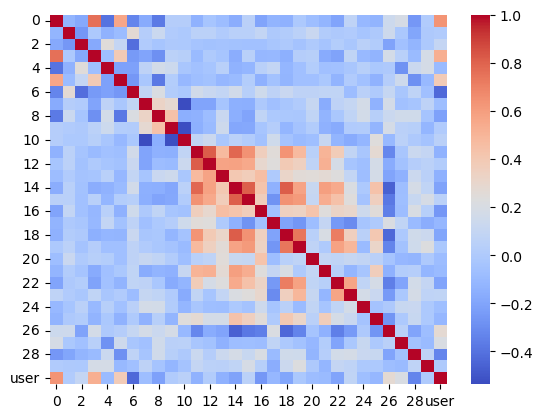

In [3]:
sns.heatmap(data.corr(), annot=False, cmap="coolwarm")

Observations:

<div class="alert alert-block alert-info">
Afficher la variance de chaque variable. Tip: utilisez seaborn et faites un boxplot.
</div>

<Axes: >

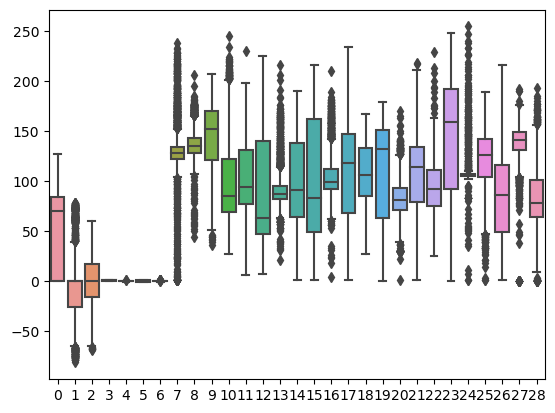

In [5]:
sns.boxplot(data=data.iloc[:, :-2])

<Axes: >

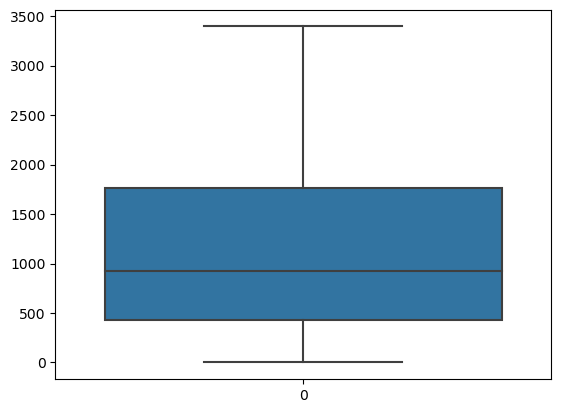

In [10]:
sns.boxplot(data=data.iloc[:, :-2].var())

Observations:

<div class="alert alert-block alert-info">
Qu’est ce qu’on observe? Quel pretraitement est adapté? (tester plusieurs)

Creer une copie du dataset avec le pretraitement appliqué.
</div>

<Axes: >

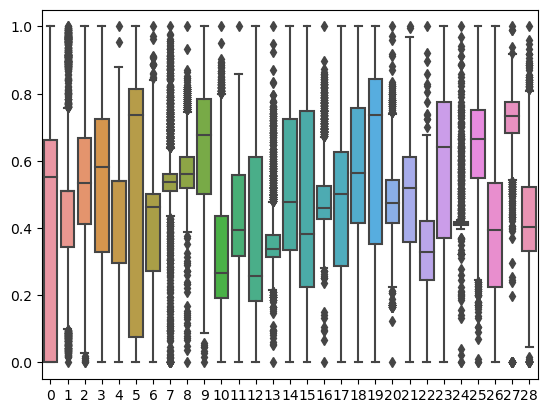

In [7]:
scaler = MinMaxScaler()

data_normalized = data.copy()
data_normalized.iloc[:, :-2] = scaler.fit_transform(data.iloc[:, :-2])

sns.boxplot(data=data_normalized.iloc[:, :-2])

Observations:

<div class="alert alert-block alert-info">
On veut comprendre quelles variables sont plus discriminantes pour déterminer la classe. En un premier temps, calculer la variance intra-classe et inter-classe pour chaque variable. Est-ce que les variables sont parlantes de la même facon ? Laquelle des deux variances est plus utile ?
</div>

In [13]:
def class_variance(df, target='target'):
    inter_class_var = []
    intra_class_var = []

    for col in df.columns[:-2]:
        inter_class_var.append(df.groupby(target)[col].mean().var())
        intra_class_var.append(df.groupby(target)[col].var().mean())

    return np.array(inter_class_var), np.array(intra_class_var)

inter_class_var, intra_class_var = class_variance(data_normalized)
print(f"Inter-class ascending variance: {inter_class_var.argsort()}")
print(f"Intra-class ascending variance: {intra_class_var.argsort()}")


Inter-class ascending variance: [ 1  2  0 24 20 27  6  8 28 16 13  7  3  5 22  4 25 26 11  9 10 18 21 23
 17 14 19 15 12]
Intra-class ascending variance: [24 22 11 13  8 23 12 10 15 14 19 16 18 27  7  9 25 20 21 17 28  4  6  2
 26  1  3  0  5]


<div class="alert alert-block alert-info">
Faire un boxplot pour chaque classe pour les variables plus et moins discriminantes.
</div>

In [25]:
def box_plot(df, target='target', cols=[]):
    fig, ax = plt.subplots(2, 4, figsize=(15, 5))
    for col in cols:
        sns.boxplot(x=target, y=col, data=df, ax=ax[cols.index(col) // 4, cols.index(col) % 4])
    plt.tight_layout()

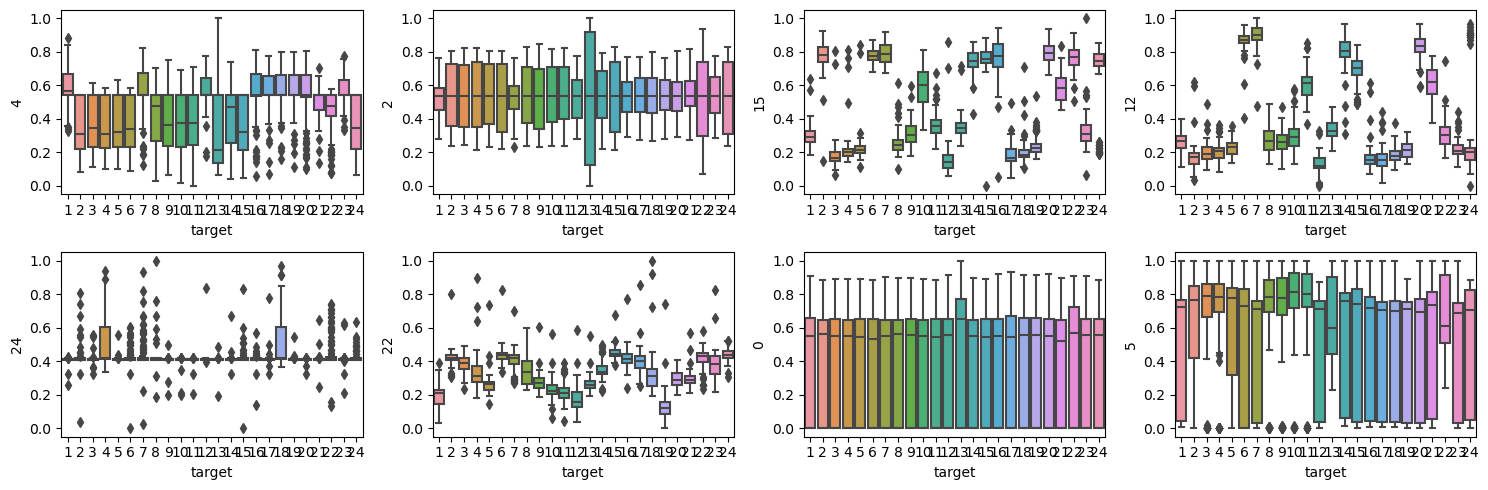

In [29]:
box_plot(data_normalized, cols=[4,2,15,12,24,22,0,5])

Observations: on voit que la colonne 12 est plus discriminante.

<div class="alert alert-block alert-info">
Qu'est ce qu'on peut dire par rapport à la diversité des utilisateurs?
</div>

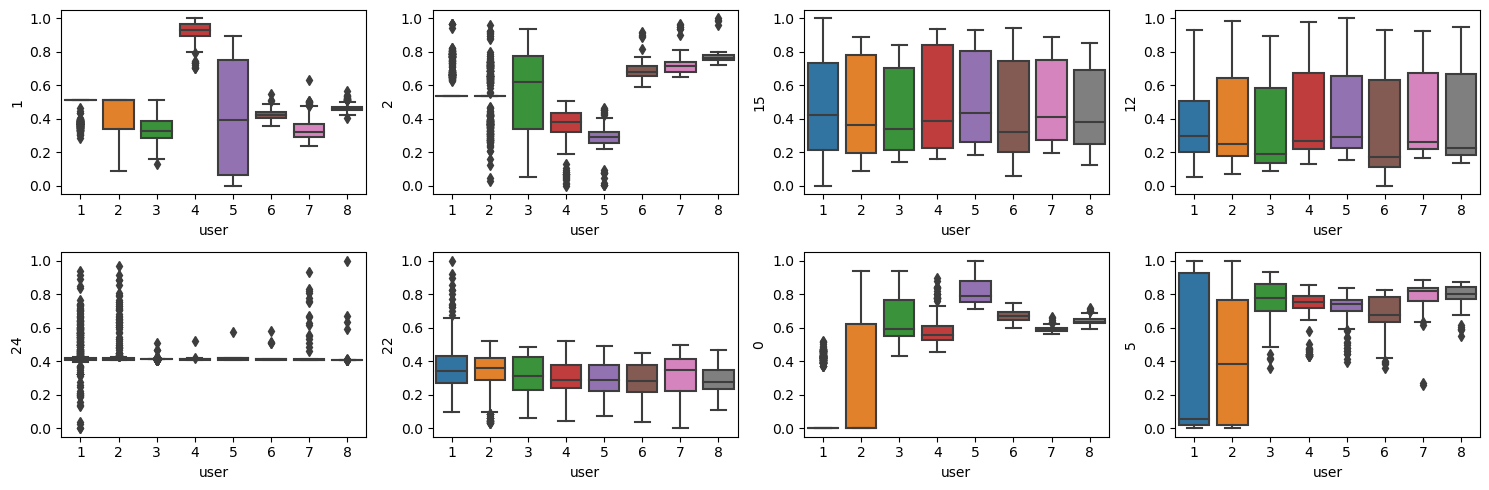

In [27]:
box_plot(data_normalized, cols=[1,2,15,12,24,22,0,5], target='user')

Observations:

<div class="alert alert-block alert-info">
En utilisant la librairie statsmodels, utiliser la fonction OLS pour estimer un modèle de régression linéaire multiple. Utiliser la variable cible comme variable dépendante et les variables prédicteurs comme variables indépendantes. Afficher le résumé du modèle. Quelle est la variable qui a le coefficient le plus élevé? Quelle est la valeur de son coefficient? Qu'est-ce que cela signifie?
</div>

In [28]:
data_ols = data.copy()

data_ols.columns = [f"X{i}" for i in range(29)] + ["target", "user"]
formula = f"target ~ {' + '.join(['X' + str(i) for i in range(29)])}"
print(formula)
ols(formula, data=data_ols).fit().summary()

target ~ X0 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X20 + X21 + X22 + X23 + X24 + X25 + X26 + X27 + X28


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     28.09
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          1.36e-129
Time:                        14:59:13   Log-Likelihood:                -7694.3
No. Observations:                2400   AIC:                         1.545e+04
Df Residuals:                    2370   BIC:                         1.562e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.8767      2.263      7.898      0.000      13.438      22.315
X0            -0.0266      0.007     -3.559      0.000      -0.041      -0.012
X1            -0.0056      0.004     -1.256      0.209      -0.014       0.003
X2            -0.0113      0.007     -1.570      0.117      -0.025       0.003
X3             9.3204      0.923     10.097      0.000       7.510      11.130
X4             3.5580      0.633      5.621      0.000       2.317       4.799
X5            -1.5455      0.239     -6.471      0.000      -2.014      -1.077
X6            -1.3331      0.637     -2.092      0.037      -2.582      -0.084
X7             0.0314      0.005      6.209      0.000       0.021       0.041
X8             0.0078      0.012      0.667      0.505      -0.015       0.031
X9            -0.0506      0.006     -8.807      0.000      -0.062      -0.039
X10           -0.0162      0.005     -3.582      0.000      -0.025      -0.007
X11            0.0639      0.010      6.422      0.000       0.044       0.083
X12           -0.0155      0.005     -3.253      0.001      -0.025      -0.006
X13            0.0134      0.009      1.539      0.124      -0.004       0.031
X14           -0.0273      0.011     -2.472      0.013      -0.049      -0.006
X15            0.0311      0.005      6.585      0.000       0.022       0.040
X16           -0.0069      0.008     -0.913      0.361      -0.022       0.008
X17           -0.0199      0.003     -5.755      0.000      -0.027      -0.013
X18           -0.0117      0.013     -0.884      0.377      -0.038       0.014
X19            0.0132      0.005      2.428      0.015       0.003       0.024
X20           -0.0197      0.007     -2.690      0.007      -0.034      -0.005
X21           -0.0296      0.005     -5.444      0.000      -0.040      -0.019
X22           -0.0188      0.010     -1.821      0.069      -0.039       0.001
X23           -0.0110      0.003     -3.147      0.002      -0.018      -0.004
X24           -0.0020      0.008     -0.242      0.809      -0.018       0.014
X25           -0.0003      0.005     -0.054      0.957      -0.011       0.010
X26           -0.0049      0.003     -1.464      0.143      -0.012       0.002
X27            0.0053      0.007      0.781      0.435      -0.008       0.019
X28           -0.0076      0.005     -1.476      0.140      -0.018       0.002
==============================================================================
Omnibus:                       31.564   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.481
Skew:                          -0.160   Prob(JB):                     4.83e-06
Kurtosis:                       2.623   Cond. No.                     9.65e+03
==============================================================================

N

Observations:

<div class="alert alert-block alert-info">
Ce sont les memes resultats que ceux obtenus avec la variance? Pourquoi?
</div>

non ce ne sont pas les mêmes résultats.

Observations:


# Protocole experimental

<div class="alert alert-block alert-info">
Dans cette section, nous allons définir le protocole expérimental, c'est-à-dire les métriques et la manière cohérente dont nous allons évaluer tous nos modèles.
</div>

<div class="alert alert-block alert-info">
Quelles sont les metriques adaptées pour ce problème? Créez une fonction scorer qui prend en argument la liste des classes prédites et la liste des ground truth et qui nous renvoie un tuple ou un dictionnaire avec toutes les metriques utiles (cf. cours).
</div>

In [62]:
def scorer(pred, actual):
    metric1 = accuracy_score(actual, pred)
    metric2 = precision_score(actual, pred, average='weighted')
    metric3 = recall_score(actual, pred, average='weighted')
    metric4 = f1_score(actual, pred, average='weighted')
    # prendre deux chiffres après la virgule
    return round(metric1, 2), round(metric2, 2), round(metric3, 2), round(metric4, 2)

<div class="alert alert-block alert-info">
Comment évaluer les modèles sur ces données ? Est-il judicieux de réaliser des séparations aléatoires entre les données d'entraînement et de test ? Est-il conseillé d'inclure un même utilisateur à la fois dans le jeu d'entraînement et dans le jeu de test ? Pourquoi ?

Créez une fonction nommée kfold, destinée à la validation croisée, qui accepte un DataFrame en entrée et génère un tuple de DataFrames, avec tous les utilisateurs sauf un pour l'entraînement, et le dernier pour le test.
</div>

In [33]:
def test_() : 
    for i in range(10) : 
        yield i


In [40]:
def kfold(data):
    users = data['user'].unique()
    for i in users:
        data_users_sans_i = data[data['user'] != i]
        data_user_i = data[data['user'] == i]
        yield data_users_sans_i, data_user_i

# Experiences
<div class="alert alert-block alert-info">
Prenez trois modèles (SVM, Arbre de décision, MLP) et, en utilisant Scikit-learn (svm.SVC, tree.DecisionTreeClassifier, MLPClassifier), appliquez-les dans un cadre de validation croisée (données normalisées ou pas?). Stockez les résultats pour chaque pli (fold) et métrique.
</div>

In [60]:
def protocol_pipeline(data, model):
    list_of_metrics_per_fold = []
    for train_df, test_df in kfold(data):

        # Training the model
        model.fit(train_df.iloc[:, : -2], train_df['target'])

        # Making predictions
        y_pred = model.predict(test_df.iloc[: , :-2])

        # Calculating metrics
        metrics = scorer(test_df['target'], y_pred)
        list_of_metrics_per_fold.append(metrics)

    return list_of_metrics_per_fold

In [68]:
import warnings
warnings.filterwarnings("ignore")

# Applying the pipeline to the models
models = [SVC(), DecisionTreeClassifier(), MLPClassifier()]

results = {}
for model in models:
    metric = protocol_pipeline(data_normalized, model)
    results[model.__class__.__name__] = metric

# Analyse
<div class="alert alert-block alert-info">
Pour chaque modele, calculer la moyenne des scores pour chaque métrique (accuracy, precision, recall, f1). Quel modèle est le meilleur?
</div>

In [69]:
def calc_moy(metrics):
    metrics = np.array(metrics)
    mean_scores = metrics.mean(axis=0)
    # prendre deux chiffres après la virgule
    print(f"Accuracy: {mean_scores[0]:.2f}, Precision: {mean_scores[1]:.2f}, Recall: {mean_scores[2]:.2f}, F1: {mean_scores[3]:.2f}")


for i, model in enumerate(results.keys()):
    print(f"Model: {model}")
    calc_moy(results[model])
    print()

Model: SVC
Accuracy: 0.94, Precision: 0.95, Recall: 0.94, F1: 0.94

Model: DecisionTreeClassifier
Accuracy: 0.83, Precision: 0.88, Recall: 0.83, F1: 0.83

Model: MLPClassifier
Accuracy: 0.91, Precision: 0.94, Recall: 0.91, F1: 0.92



<div class="alert alert-block alert-info">
Pour chaque métrique et chaque paire de classificateurs, on peut réaliser un test de Student pour vérifier si la différence entre les moyennes est significative (sur les differents folds, pas la moyenne des metriques). Est-ce le cas? Il y a un modèle qui est significativement meilleur?
</div>

In [70]:
# Tip: student test with ttest_ind
# Pythonic tip: itertools.combinations
for metric_index, metric_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    print(f"\n{metric_name}:")
    for model1, model2 in combinations(results.keys(), 2):
        scores_model1 = np.array(results[model1])[:, metric_index]
        scores_model2 = np.array(results[model2])[:, metric_index]
        t_stat, p_val = ttest_ind(scores_model1, scores_model2)
        print(f"{model1} vs {model2}: t-statistic = {t_stat}, p-value = {p_val}")


Accuracy:
SVC vs DecisionTreeClassifier: t-statistic = 4.059236742057712, p-value = 0.0011718808926917954
SVC vs MLPClassifier: t-statistic = 1.6032970581750194, p-value = 0.13118407411427793
DecisionTreeClassifier vs MLPClassifier: t-statistic = -3.0802201954860844, p-value = 0.008146180134934691

Precision:
SVC vs DecisionTreeClassifier: t-statistic = 3.7035343124332214, p-value = 0.002360743968807462
SVC vs MLPClassifier: t-statistic = 0.7035975447302896, p-value = 0.4932200846341359
DecisionTreeClassifier vs MLPClassifier: t-statistic = -3.116151472569976, p-value = 0.007585075500023976

Recall:
SVC vs DecisionTreeClassifier: t-statistic = 4.059236742057712, p-value = 0.0011718808926917954
SVC vs MLPClassifier: t-statistic = 1.6032970581750194, p-value = 0.13118407411427793
DecisionTreeClassifier vs MLPClassifier: t-statistic = -3.0802201954860844, p-value = 0.008146180134934691

F1:
SVC vs DecisionTreeClassifier: t-statistic = 4.007277761557721, p-value = 0.0012974032957136896
SV

In [71]:
data = []
for metric_index, metric_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    for model1, model2 in combinations(results.keys(), 2):
        scores_model1 = np.array(results[model1])[:, metric_index]
        scores_model2 = np.array(results[model2])[:, metric_index]
        t_stat, p_val = ttest_ind(scores_model1, scores_model2)
        data.append({
            'Metric': metric_name,
            'Model1': model1,
            'Model2': model2,
            'T-Statistic': t_stat,
            'P-Value': p_val
        })

df = pd.DataFrame(data)
df

,Metric,Model1,Model2,T-Statistic,P-Value
0,Accuracy,SVC,DecisionTreeClassifier,4.059237,0.001172
1,Accuracy,SVC,MLPClassifier,1.603297,0.131184
2,Accuracy,DecisionTreeClassifier,MLPClassifier,-3.080220,0.008146
3,Precision,SVC,DecisionTreeClassifier,3.703534,0.002361
4,Precision,SVC,MLPClassifier,0.703598,0.493220
5,Precision,DecisionTreeClassifier,MLPClassifier,-3.116151,0.007585
6,Recall,SVC,DecisionTreeClassifier,4.059237,0.001172
7,Recall,SVC,MLPClassifier,1.603297,0.131184
8,Recall,DecisionTreeClassifier,MLPClassifier,-3.080220,0.008146
9,F1,SVC,DecisionTreeClassifier,4.007278,0.001297


<div class="alert alert-block alert-info">
Prendre le meilleur modèle et analyser ses erreurs. Pour le faire, afficher la matrice de confusion. Qu'est ce qu'on en déduit?
</div>

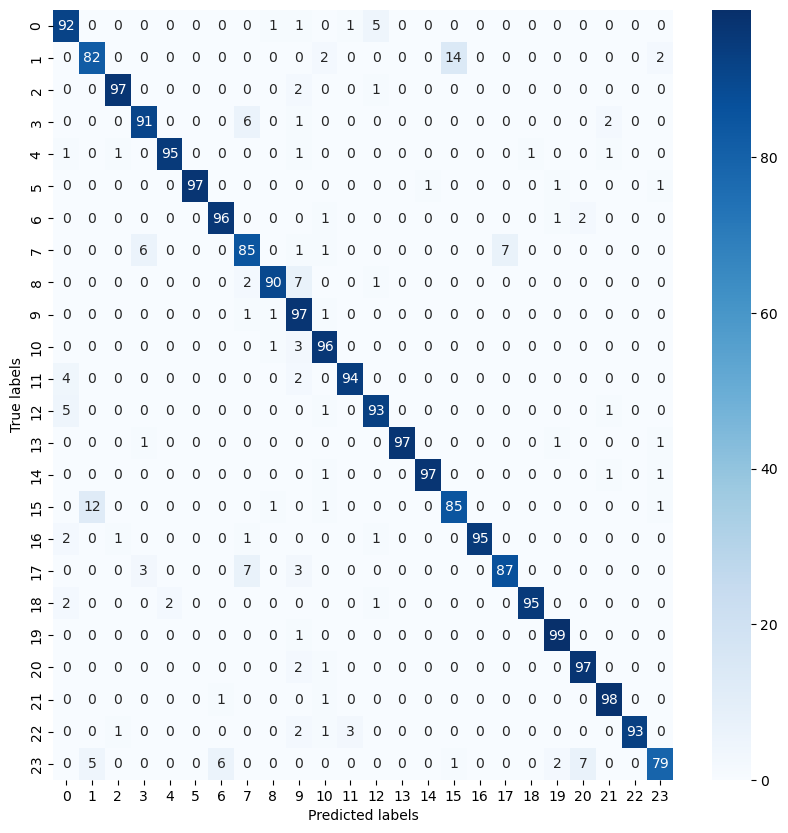

In [78]:
matrice_confusion = np.zeros((24, 24))

for train_df, test_df in kfold(data_normalized):
    model = SVC()
    model.fit(train_df.iloc[:, :-2], train_df['target'])
    y_pred = model.predict(test_df.iloc[:, :-2])
    matrice_confusion += confusion_matrix(test_df['target'], y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(matrice_confusion, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<div class="alert alert-block alert-info">
<b>Pour aller plus loin</b> - Analyser les résultats de la classification et avec les résultats des tests statistiques, trouver les colonnes qui sont les plus importantes pour la classification, essayer de virer les colonnes qui ne sont pas importantes et refaire la classification, aussi essayer de faire une petite recherche des hyperparamètres, puis comparer les résultats avec les résultats obtenus ici.
</div>